*Christian Camilo Urcuqui López*

Liveness detection system & adversarial machine learning application.


# Introduction

On this notebook you can find the application of adversarial machine learning in a open box scenario for a prototype for a liveness detection system. The resource is divided in the next sections:

+ [Liveness Detection Algorithm](#Liveness-Detection-Algorithm)
    + [Dataset](#Dataset)
    + [Model Training](#Model-training)
    + [Model Testing](#Model-testing)
+ [Adversarial Machine Learning](#Adversarial-Machine-Learning)
+ [Security Measures](#Security-Measures)

## Liveness Detection Algorithm
 
Create a machine learning model to distinguish between live individuals and non-live entities (e.g., photos, video replays, masks). Describe your model selection, feature engineering, and training process.


### Dataset

The datasource is part of the resources provided by the paper:
```
X.Tan, Y.Li, J.Liu and L.Jiang.
Face Liveness Detection from A Single Image with Sparse Low Rank Bilinear Discriminative Model, 
In: Proceedings of 11th European Conference on Computer Vision (ECCV'10), Crete, Greece. September 2010
```
The article explores the problem related to spoofing with photograph or video in a face recognition system. In the paper, they presents a method to adderss this based on individual images from a generic webcamera. Moreover, the researchers provided a set of images with the labels (real and fake) that are going to be used for this work.  

+ https://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/xtan/NUAAImposterDB_download.html

It is important to mention that part of this unit is based on the code proposed in the next tutorial. 

+ https://medium.com/@hazqeelafyq09/optimizing-face-liveness-detection-with-pretrained-vit-base-a-step-by-step-tutorial-8b9c8794ab7d

*Libraries for the Liveness Detection Algorithm*

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import time
from sklearn.metrics import f1_score
import timm
from timm.models.layers import trunc_normal_
from ellzaf_ml.tools import EarlyStopping

C:\Users\Usuario\Anaconda3\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The next are some of the hyperparameters that are going to be taken.

In [4]:
EPOCHS = 500
PATIENCE = 3
BATCH_SIZE = 16
EPOCH_LEN = len(str(EPOCHS))
lr = 3e-5
torch.manual_seed(39)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

device = torch.device(device)

Using cuda device


The next class allows us to transform each image with a set of treatments.

In [6]:

class CustomDataset(datasets.ImageFolder):
    def __init__(self, root, special_augment_transform=None, general_augment_transform=None, special_classes=None):
        super().__init__(root)
        
        if special_augment_transform is not None and not callable(special_augment_transform):
            raise ValueError("special_augment_transform must be a callable or None")
        if general_augment_transform is not None and not callable(general_augment_transform):
            raise ValueError("general_augment_transform must be a callable or None")

        if special_classes is not None:
            if not isinstance(special_classes, (set, list, tuple)):
                raise TypeError("special_classes must be a set, list, or tuple")
            self.special_classes = set(special_classes)
        else:
            self.special_classes = set()

        self.special_augment_transform = special_augment_transform
        self.general_augment_transform = general_augment_transform

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        class_name = self.classes[label]
        if class_name in self.special_classes and self.special_augment_transform:
            image = self.special_augment_transform(image)
        elif self.general_augment_transform:
            image = self.general_augment_transform(image)

        return image, label

There are three transform implementations:,
+ `transform_original`, it is oriented to be applied for the "real" images, it applies a resize, a movement and a normalization of the pixels. 
+ `spoof_transforms`, it is applied to the "fake" images, it peforms a resize, a movement of the image, some changes of the color and other characteristics(brightness, contrast, saturation, RandomGrayscale, and GaussianBlur).
+ `transform_flipped`, it is oriented to be applied to images without a label.

In [7]:
transform_original = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

spoof_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomHorizontalFlip(p=1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
])

transform_flipped = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


We have a classification problem, so for this case, we have divided our dataset of images into three parts: training, validation, and testing. The last sources will be used to develop our model and test if it performs well for overfitting and underfitting.

In [8]:
train_orig = datasets.ImageFolder("face_train", transform=transform_original)
train_flip = CustomDataset(root="face_train",
                           general_augment_transform=transform_flipped,
                           special_augment_transform=spoof_transforms,
                           special_classes=['fake'])

train_data_combined = ConcatDataset([train_orig, train_flip])
train_loader = DataLoader(train_data_combined, batch_size=BATCH_SIZE, shuffle=True)

val_orig = datasets.ImageFolder("face_val", transform=transform_original)
val_flip = CustomDataset(root="face_val",
                           general_augment_transform=transform_flipped,
                           special_augment_transform=spoof_transforms,
                           special_classes=['fake'])

val_data_combined = ConcatDataset([val_orig, val_flip])
val_loader = DataLoader(val_data_combined, batch_size=BATCH_SIZE, shuffle=False)

test_orig = datasets.ImageFolder("face_test", transform=transform_original)
test_loader = DataLoader(test_orig, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
print(len(train_data_combined),len(val_data_combined),len(test_orig))

13510 6286 2716


## Model training

In [10]:
def train_one_epoch(model, train_loader, device, optimizer, criterion, scheduler_lr=None):
    model.train()
    total_loss, total_f1, total_correct, total_samples, total_grad = 0, 0, 0, 0, 0

    for idx, (train_x_data, train_y_data) in enumerate(train_loader):
        train_x_data, train_y_data = train_x_data.to(device), train_y_data.to(device)
        optimizer.zero_grad()
        y_pred = model(train_x_data)

        loss = criterion(y_pred, train_y_data)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
        optimizer.step()

        _, y_pred_max = torch.max(y_pred, dim=1)
        f1_score_val = f1_score(train_y_data.cpu(), y_pred_max.cpu(), average="macro")
        total_correct += (y_pred_max == train_y_data).sum().item()
        total_samples += train_y_data.size(0)
        total_loss += loss.item()
        total_f1 += f1_score_val.item()
        total_grad += grad_norm

        if idx % 10 == 0 and idx > 0:
            lr = optimizer.param_groups[0]['lr']
            print(
                f'[{e:>{EPOCH_LEN}}/{EPOCHS:>{EPOCH_LEN}}] [{idx}/{len(train_loader)}] '
                f'lr {lr:.10f} | loss {loss:.10f} ({total_loss/idx:.4f}) | '
                f'grad_norm {grad_norm:.4f} ({total_grad/idx:.4f}) | '
            )

    if scheduler_lr:
        scheduler_lr.step()
    avg_loss = total_loss / len(train_loader)
    avg_f1 = total_f1 / len(train_loader)
    avg_grad = total_grad / len(train_loader)
    accuracy = total_correct / total_samples
    return avg_loss, avg_f1, accuracy, avg_grad

In [11]:
def validate_one_epoch(model, val_loader, device, criterion, scheduler_lr=None):
    model.eval()
    total_loss, total_f1, total_correct, total_samples = 0, 0, 0, 0

    with torch.no_grad():
        for val_x_data, val_y_data in val_loader:
            val_x_data, val_y_data = val_x_data.to(device), val_y_data.to(device)
            y_val_pred = model(val_x_data)
            val_loss = criterion(y_val_pred, val_y_data)

            _, y_val_pred_max = torch.max(y_val_pred, dim=1)
            f1_score_val = f1_score(val_y_data.cpu(), y_val_pred_max.cpu(), average="macro")
            total_correct += (y_val_pred_max == val_y_data).sum().item()
            total_samples += val_y_data.size(0)
            total_loss += val_loss.item()
            total_f1 += f1_score_val.item()

    avg_loss = total_loss / len(val_loader)
    if scheduler_lr:
        scheduler_lr.step(avg_loss)
    avg_f1 = total_f1 / len(val_loader)
    accuracy = total_correct / total_samples
    return avg_loss, avg_f1, accuracy

In [14]:
model = timm.create_model('vit_base_patch16_224.augreg_in21k_ft_in1k', pretrained=True)
model.head = torch.nn.Linear(model.head.in_features, 2)
trunc_normal_(model.head.weight, mean=0.0, std=0.02)
model = model.to(device)

criterion = nn.CrossEntropyLoss() # we have a classification problem - binary

optimizer = optim.Adam(model.parameters(), lr=lr)
#methods to adjust the learning rate based on the number of epochs
scheduler_linear = lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=10)
scheduler_cosine = lr_scheduler.CosineAnnealingLR(optimizer, T_max=490, eta_min=lr/100)
scheduler_lr = lr_scheduler.SequentialLR(optimizer, [scheduler_linear,scheduler_cosine],milestones=[10])

early_stopping = EarlyStopping(
                    patience=PATIENCE,
                    verbose=True,
                    path=f"weights/vit_teacher.pth",
                )

start_time = time.time()
for e in range(1, EPOCHS + 1):
    avg_loss_train, avg_f1_train, avg_accuracy_train, avg_grad = train_one_epoch(model, train_loader, device,
                                                                           optimizer, criterion, scheduler_lr)
    avg_loss_val, avg_f1_val, avg_accuracy_val = validate_one_epoch(model, val_loader, device, criterion)

    time_taken = time.time() - start_time
    time_format = time.strftime("%H:%M:%S", time.gmtime(time_taken))

    print(
    f"[{e:>{EPOCH_LEN}}/{EPOCHS:>{EPOCH_LEN}}] Loss: {avg_loss_train:.5f} | "
    + f"F1-score: {avg_f1_train:.3f} | Acc: {avg_accuracy_train:.3f} | "
    + f"Val Loss: {avg_loss_val:.3f} | Val F1: {avg_f1_val:.3f} | "
    + f"Val Acc: {avg_accuracy_val:.3f} | {time_format}s | "
    + f"Grad: {avg_grad:.5f}"
    )


    early_stopping(avg_loss_val, model)
    if early_stopping.early_stop:
        print(f"Early stopping after {e} Epochs")
        break

[  1/500] [10/845] lr 0.0000003000 | loss 2.4422533512 (2.3906) | grad_norm 169.8696 (154.0096) | 
[  1/500] [20/845] lr 0.0000003000 | loss 0.7042943835 (1.7854) | grad_norm 86.7347 (130.4804) | 
[  1/500] [30/845] lr 0.0000003000 | loss 0.4118837714 (1.3968) | grad_norm 57.1991 (108.3430) | 
[  1/500] [40/845] lr 0.0000003000 | loss 0.3329927325 (1.1318) | grad_norm 38.9590 (90.2518) | 
[  1/500] [50/845] lr 0.0000003000 | loss 0.1117465124 (0.9648) | grad_norm 14.3774 (77.5135) | 
[  1/500] [60/845] lr 0.0000003000 | loss 0.1055727303 (0.8385) | grad_norm 11.7552 (67.9549) | 
[  1/500] [70/845] lr 0.0000003000 | loss 0.2656383216 (0.7427) | grad_norm 21.0429 (60.9591) | 
[  1/500] [80/845] lr 0.0000003000 | loss 0.0979519859 (0.6670) | grad_norm 9.4131 (55.2081) | 
[  1/500] [90/845] lr 0.0000003000 | loss 0.1129827350 (0.6053) | grad_norm 13.4847 (50.6020) | 
[  1/500] [100/845] lr 0.0000003000 | loss 0.0756156668 (0.5549) | grad_norm 10.9007 (46.9078) | 
[  1/500] [110/845] lr 0.0

[  2/500] [10/845] lr 0.0000032700 | loss 0.0002126230 (0.0015) | grad_norm 0.0623 (0.4025) | 
[  2/500] [20/845] lr 0.0000032700 | loss 0.0004706332 (0.0013) | grad_norm 0.0952 (0.3801) | 
[  2/500] [30/845] lr 0.0000032700 | loss 0.0004092576 (0.0011) | grad_norm 0.0605 (0.3264) | 
[  2/500] [40/845] lr 0.0000032700 | loss 0.0001998021 (0.0010) | grad_norm 0.0475 (0.3140) | 
[  2/500] [50/845] lr 0.0000032700 | loss 0.0001847846 (0.0009) | grad_norm 0.0314 (0.2836) | 
[  2/500] [60/845] lr 0.0000032700 | loss 0.0005931609 (0.0008) | grad_norm 0.2502 (0.2484) | 
[  2/500] [70/845] lr 0.0000032700 | loss 0.0001047545 (0.0007) | grad_norm 0.0172 (0.2379) | 
[  2/500] [80/845] lr 0.0000032700 | loss 0.0002688249 (0.0007) | grad_norm 0.0721 (0.2172) | 
[  2/500] [90/845] lr 0.0000032700 | loss 0.0004960407 (0.0006) | grad_norm 0.1551 (0.2059) | 
[  2/500] [100/845] lr 0.0000032700 | loss 0.0001420559 (0.0006) | grad_norm 0.0514 (0.1900) | 
[  2/500] [110/845] lr 0.0000032700 | loss 0.0001

[  3/500] [10/845] lr 0.0000062400 | loss 0.0000562730 (0.0002) | grad_norm 0.0256 (0.1181) | 
[  3/500] [20/845] lr 0.0000062400 | loss 0.0007058122 (0.0002) | grad_norm 0.3807 (0.1347) | 
[  3/500] [30/845] lr 0.0000062400 | loss 0.0000071673 (0.0002) | grad_norm 0.0020 (0.1286) | 
[  3/500] [40/845] lr 0.0000062400 | loss 0.0000407391 (0.0002) | grad_norm 0.0221 (0.0984) | 
[  3/500] [50/845] lr 0.0000062400 | loss 0.0000332163 (0.0001) | grad_norm 0.0190 (0.0798) | 
[  3/500] [60/845] lr 0.0000062400 | loss 0.0000181043 (0.0001) | grad_norm 0.0066 (0.0670) | 
[  3/500] [70/845] lr 0.0000062400 | loss 0.0000097601 (0.0001) | grad_norm 0.0028 (0.0587) | 
[  3/500] [80/845] lr 0.0000062400 | loss 0.0000042617 (0.0001) | grad_norm 0.0018 (0.0517) | 
[  3/500] [90/845] lr 0.0000062400 | loss 0.0000046566 (0.0001) | grad_norm 0.0014 (0.0462) | 
[  3/500] [100/845] lr 0.0000062400 | loss 0.0004891431 (0.0001) | grad_norm 0.3020 (0.0451) | 
[  3/500] [110/845] lr 0.0000062400 | loss 0.0000

[  4/500] [10/845] lr 0.0000092100 | loss 0.0000164343 (0.0000) | grad_norm 0.0073 (0.0012) | 
[  4/500] [20/845] lr 0.0000092100 | loss 0.0000021830 (0.0000) | grad_norm 0.0006 (0.0009) | 
[  4/500] [30/845] lr 0.0000092100 | loss 0.0000061988 (0.0000) | grad_norm 0.0019 (0.0008) | 
[  4/500] [40/845] lr 0.0000092100 | loss 0.0000029430 (0.0000) | grad_norm 0.0007 (0.0007) | 
[  4/500] [50/845] lr 0.0000092100 | loss 0.0000013560 (0.0000) | grad_norm 0.0002 (0.0008) | 
[  4/500] [60/845] lr 0.0000092100 | loss 0.0000013709 (0.0000) | grad_norm 0.0003 (0.0008) | 
[  4/500] [70/845] lr 0.0000092100 | loss 0.0000214548 (0.0000) | grad_norm 0.0099 (0.0009) | 
[  4/500] [80/845] lr 0.0000092100 | loss 0.0000045895 (0.0000) | grad_norm 0.0012 (0.0020) | 
[  4/500] [90/845] lr 0.0000092100 | loss 0.0000017509 (0.0000) | grad_norm 0.0003 (0.0019) | 
[  4/500] [100/845] lr 0.0000092100 | loss 0.0000019222 (0.0000) | grad_norm 0.0006 (0.0018) | 
[  4/500] [110/845] lr 0.0000092100 | loss 0.0000

[  5/500] [10/845] lr 0.0000121800 | loss 0.0000003502 (0.0000) | grad_norm 0.0001 (0.0005) | 
[  5/500] [20/845] lr 0.0000121800 | loss 0.0000003651 (0.0000) | grad_norm 0.0001 (0.0007) | 
[  5/500] [30/845] lr 0.0000121800 | loss 0.0000020414 (0.0000) | grad_norm 0.0006 (0.0007) | 
[  5/500] [40/845] lr 0.0000121800 | loss 0.0000042915 (0.0000) | grad_norm 0.0014 (0.0007) | 
[  5/500] [50/845] lr 0.0000121800 | loss 0.0000012591 (0.0000) | grad_norm 0.0004 (0.0006) | 
[  5/500] [60/845] lr 0.0000121800 | loss 0.0000001490 (0.0000) | grad_norm 0.0000 (0.0007) | 
[  5/500] [70/845] lr 0.0000121800 | loss 0.0000003502 (0.0000) | grad_norm 0.0001 (0.0006) | 
[  5/500] [80/845] lr 0.0000121800 | loss 0.0000004172 (0.0000) | grad_norm 0.0001 (0.0006) | 
[  5/500] [90/845] lr 0.0000121800 | loss 0.0000002608 (0.0000) | grad_norm 0.0001 (0.0007) | 
[  5/500] [100/845] lr 0.0000121800 | loss 0.0000002682 (0.0000) | grad_norm 0.0001 (0.0007) | 
[  5/500] [110/845] lr 0.0000121800 | loss 0.0000

[  6/500] [10/845] lr 0.0000151500 | loss 0.0000009835 (0.0000) | grad_norm 0.0004 (0.0003) | 
[  6/500] [20/845] lr 0.0000151500 | loss 0.0000005364 (0.0000) | grad_norm 0.0002 (0.0002) | 
[  6/500] [30/845] lr 0.0000151500 | loss 0.0000004023 (0.0000) | grad_norm 0.0001 (0.0002) | 
[  6/500] [40/845] lr 0.0000151500 | loss 0.0000001863 (0.0000) | grad_norm 0.0000 (0.0002) | 
[  6/500] [50/845] lr 0.0000151500 | loss 0.0000027492 (0.0000) | grad_norm 0.0010 (0.0002) | 
[  6/500] [60/845] lr 0.0000151500 | loss 0.0000002086 (0.0000) | grad_norm 0.0001 (0.0003) | 
[  6/500] [70/845] lr 0.0000151500 | loss 0.0000003278 (0.0000) | grad_norm 0.0002 (0.0002) | 
[  6/500] [80/845] lr 0.0000151500 | loss 0.0000017583 (0.0000) | grad_norm 0.0008 (0.0002) | 
[  6/500] [90/845] lr 0.0000151500 | loss 0.0000004843 (0.0000) | grad_norm 0.0002 (0.0003) | 
[  6/500] [100/845] lr 0.0000151500 | loss 0.0000001416 (0.0000) | grad_norm 0.0001 (0.0003) | 
[  6/500] [110/845] lr 0.0000151500 | loss 0.0000

[  7/500] [10/845] lr 0.0000181200 | loss 0.0000006631 (0.0000) | grad_norm 0.0002 (0.0002) | 
[  7/500] [20/845] lr 0.0000181200 | loss 0.0000002310 (0.0000) | grad_norm 0.0001 (0.0001) | 
[  7/500] [30/845] lr 0.0000181200 | loss 0.0000000596 (0.0000) | grad_norm 0.0000 (0.0002) | 
[  7/500] [40/845] lr 0.0000181200 | loss 0.0000006556 (0.0000) | grad_norm 0.0003 (0.0001) | 
[  7/500] [50/845] lr 0.0000181200 | loss 0.0000003204 (0.0000) | grad_norm 0.0001 (0.0001) | 
[  7/500] [60/845] lr 0.0000181200 | loss 0.0000002459 (0.0000) | grad_norm 0.0001 (0.0001) | 
[  7/500] [70/845] lr 0.0000181200 | loss 0.0000001490 (0.0000) | grad_norm 0.0001 (0.0001) | 
[  7/500] [80/845] lr 0.0000181200 | loss 0.0000007302 (0.0000) | grad_norm 0.0004 (0.0001) | 
[  7/500] [90/845] lr 0.0000181200 | loss 0.0000001267 (0.0000) | grad_norm 0.0000 (0.0001) | 
[  7/500] [100/845] lr 0.0000181200 | loss 0.0000001714 (0.0000) | grad_norm 0.0000 (0.0001) | 
[  7/500] [110/845] lr 0.0000181200 | loss 0.0000

[  8/500] [10/845] lr 0.0000210900 | loss 0.0000001416 (0.0000) | grad_norm 0.0000 (0.0001) | 
[  8/500] [20/845] lr 0.0000210900 | loss 0.0000000447 (0.0000) | grad_norm 0.0000 (0.0000) | 
[  8/500] [30/845] lr 0.0000210900 | loss 0.0000000820 (0.0000) | grad_norm 0.0000 (0.0000) | 
[  8/500] [40/845] lr 0.0000210900 | loss 0.0000000224 (0.0000) | grad_norm 0.0000 (0.0000) | 
[  8/500] [50/845] lr 0.0000210900 | loss 0.0000007525 (0.0000) | grad_norm 0.0005 (0.0001) | 
[  8/500] [60/845] lr 0.0000210900 | loss 0.0000000969 (0.0000) | grad_norm 0.0000 (0.0001) | 
[  8/500] [70/845] lr 0.0000210900 | loss 0.0000000000 (0.0000) | grad_norm 0.0000 (0.0001) | 
[  8/500] [80/845] lr 0.0000210900 | loss 0.0000002086 (0.0000) | grad_norm 0.0001 (0.0001) | 
[  8/500] [90/845] lr 0.0000210900 | loss 0.0000000596 (0.0000) | grad_norm 0.0000 (0.0001) | 
[  8/500] [100/845] lr 0.0000210900 | loss 0.0000000745 (0.0000) | grad_norm 0.0000 (0.0001) | 
[  8/500] [110/845] lr 0.0000210900 | loss 0.0000

[  9/500] [10/845] lr 0.0000240600 | loss 0.0000000149 (0.0000) | grad_norm 0.0000 (0.0000) | 
[  9/500] [20/845] lr 0.0000240600 | loss 0.0000000596 (0.0000) | grad_norm 0.0000 (0.0000) | 
[  9/500] [30/845] lr 0.0000240600 | loss 0.0000003129 (0.0000) | grad_norm 0.0002 (0.0000) | 
[  9/500] [40/845] lr 0.0000240600 | loss 0.0000001267 (0.0000) | grad_norm 0.0000 (0.0000) | 
[  9/500] [50/845] lr 0.0000240600 | loss 0.0000000000 (0.0000) | grad_norm 0.0000 (0.0000) | 
[  9/500] [60/845] lr 0.0000240600 | loss 0.0000000224 (0.0000) | grad_norm 0.0000 (0.0000) | 
[  9/500] [70/845] lr 0.0000240600 | loss 0.0000000373 (0.0000) | grad_norm 0.0000 (0.0000) | 
[  9/500] [80/845] lr 0.0000240600 | loss 0.0000002086 (0.0000) | grad_norm 0.0001 (0.0000) | 
[  9/500] [90/845] lr 0.0000240600 | loss 0.0000000298 (0.0000) | grad_norm 0.0000 (0.0000) | 
[  9/500] [100/845] lr 0.0000240600 | loss 0.0000000075 (0.0000) | grad_norm 0.0000 (0.0000) | 
[  9/500] [110/845] lr 0.0000240600 | loss 0.0000

[ 10/500] [10/845] lr 0.0000270300 | loss 0.0000000298 (0.0000) | grad_norm 0.0000 (0.0000) | 
[ 10/500] [20/845] lr 0.0000270300 | loss 0.0000000149 (0.0000) | grad_norm 0.0000 (0.0000) | 
[ 10/500] [30/845] lr 0.0000270300 | loss 0.0000000075 (0.0000) | grad_norm 0.0000 (0.0000) | 
[ 10/500] [40/845] lr 0.0000270300 | loss 0.0000001267 (0.0000) | grad_norm 0.0001 (0.0000) | 
[ 10/500] [50/845] lr 0.0000270300 | loss 0.0000000075 (0.0000) | grad_norm 0.0000 (0.0000) | 
[ 10/500] [60/845] lr 0.0000270300 | loss 0.0000000224 (0.0000) | grad_norm 0.0000 (0.0000) | 
[ 10/500] [70/845] lr 0.0000270300 | loss 0.0000000224 (0.0000) | grad_norm 0.0000 (0.0000) | 
[ 10/500] [80/845] lr 0.0000270300 | loss 0.0000000075 (0.0000) | grad_norm 0.0000 (0.0000) | 
[ 10/500] [90/845] lr 0.0000270300 | loss 0.0000000149 (0.0000) | grad_norm 0.0000 (0.0000) | 
[ 10/500] [100/845] lr 0.0000270300 | loss 0.0000000149 (0.0000) | grad_norm 0.0000 (0.0000) | 
[ 10/500] [110/845] lr 0.0000270300 | loss 0.0000

C:\Users\Usuario\Anaconda3\envs\llm\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[ 10/500] Loss: 0.00000 | F1-score: 1.000 | Acc: 1.000 | Val Loss: 0.085 | Val F1: 0.886 | Val Acc: 0.970 | 01:51:11s | Grad: 0.00005
EarlyStopping counter: 3 out of 3
Early stopping after 10 Epochs


The last cell provides us with a model using an early stopping to save our model when the validation loss decreases on each epoch.

## Model Testing

The next cell includes the testing scenario of the model that was trained in the previous one.

In [15]:
model = timm.create_model('vit_base_patch16_224.augreg_in21k_ft_in1k', pretrained=True)
model.head = torch.nn.Linear(model.head.in_features, 2)
model = model.to(device)
model.load_state_dict(
    torch.load(
        "weights/vit_teacher.pth"
    )
)
model.eval()

with torch.no_grad():
    correct = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        tp += (pred.eq(1) & target.eq(1).view_as(pred)).sum().item()
        tn += (pred.eq(0) & target.eq(0).view_as(pred)).sum().item()
        fp += (pred.eq(1) & target.eq(0).view_as(pred)).sum().item()
        fn += (pred.eq(0) & target.eq(1).view_as(pred)).sum().item()

        correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / len(test_loader.dataset)
    far = fp / (fp + tn)
    frr = fn / (fn + tp)

    recall = tp / (tp + fn)

    hter = (far + frr ) / 2

    print(f"test acc: {accuracy * 100}%")
    print(f"recall: {recall * 100}%")
    print(f"far: {far * 100}%")
    print(f"frr: {frr * 100}%")
    print(f"hter: {hter * 100}%")

test acc: 99.85272459499264%
recall: 99.63996399639964%
far: 0.0%
frr: 0.36003600360036003%
hter: 0.18001800180018002%


As we can see we now have a model with a good performance evaluated using the testing dataset.

## Adversarial Machine Learning

For this approach I am going to explore the use of a "Open Box" attack where I have complete access of the model, it works well because we can compute gradients. Specifically, I am going to implement the *Targeted Carlini and Wagner L2 attack* proposed [here](https://arxiv.org/abs/1608.04644). 

The next are the libraries that are going to be used during the adversarial machine learning implementation.

In [1]:
import torch
from PIL import Image
from IPython import display

import pandas as pd
import torchvision
from torchvision import transforms
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\Usuario\Anaconda3\envs\botred\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
labels = {}
labels[0] = "fake"
labels[1] = "real"

The next is our current fake image detected by our model, our objective is to add a mask that is going to give us the capacity that the model detects as a real image. 

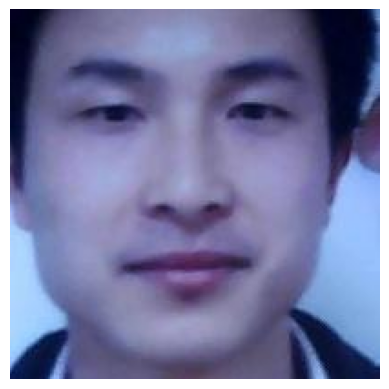

In [3]:
img = Image.open("../static/fake/0001_00_00_01_0.jpg")

plt.imshow(img)
plt.axis('off')
plt.show()

The next cell includes the code to unormalize an image to view it, moreover, it has the activities to transform an image. 

In [4]:
unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

transform_original = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def tensor_to_pil(img_tensor):    
    unnormed_tensor = unnormalize(img_tensor)
    return transforms.functional.to_pil_image(unnormed_tensor[0])

Here we are going to define the mask and the paramater that defines how much we want to change the image.

In [5]:
change = 1e-3

img_tensor = transform_original(img).unsqueeze(0)

print(f"Inputs information:\n---------------\nshape:{img_tensor.shape}\n")

mask = torch.randn_like(img_tensor)*change

Inputs information:
---------------
shape:torch.Size([1, 3, 224, 224])



In [6]:
print(mask.shape)
mask_parameter = torch.nn.Parameter(mask.to(device))
print(mask_parameter.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [7]:
# create the final image fake + noise
masked_img_tensor = img_tensor.to(device) + mask_parameter

print(f"Mask shape:\n---------------\n{mask.shape}\n")

Mask shape:
---------------
torch.Size([1, 3, 224, 224])



The next cell shows the model previously created that is going to be attacked.

In [8]:
model = timm.create_model('vit_base_patch16_224.augreg_in21k_ft_in1k', pretrained=True)
model.head = torch.nn.Linear(model.head.in_features, 2)
model = model.to(device)
model.load_state_dict(
    torch.load(
        "../weights/vit_teacher.pth"
    )
)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

The next cell defines the optimizer based on Adam and we are going to check the index predicted by the model (0-> fake, 1-> real) for the current image loaded.

In [9]:
optimizer = torch.optim.Adam([mask_parameter])

# Find our current prediction 
current_index = model(img_tensor.to(device))[0].argmax().unsqueeze(0)

In [10]:
if current_index == 0:
    print("Current prediction is fake")
else:
    print("Current prediction is real")

Current prediction is fake


The next cell loads our target image and how the model predicts it as a real. 

In [11]:
img_two = Image.open("../static/real/0001_00_00_01_0.jpg")
img_tensor_two = transform_original(img_two).unsqueeze(0)

target_index = model(img_tensor_two.to(device))[0].argmax().unsqueeze(0)
if target_index == 0: # real 1, fake 0
    print("Current prediction is fake")
else:
    print("Current prediction is real")

Current prediction is real


The method defines the loss function, here we have a cross entropy for the target index and the output of the model, moreover, it has the total loss that has the l2 weight sum by the l2 loss (no single pixel should be big, and the total magnitude of all the should be small)

In [12]:
def loss(output, mask, target_index, l2_weight):   
    classification_loss = torch.nn.functional.cross_entropy(output, target_index)    
    l2_loss = torch.pow(mask, 2).sum()    # calculate the L2 loss, elevate to the power of 2 and sum all elements
    total_loss =  classification_loss+(l2_weight * l2_loss)    
    # we are going to penalize large distortions a bit less.
    return total_loss, classification_loss, l2_loss

The next two cells are examples of the attack

In [13]:
import sys

# provided code
img_tensor = img_tensor.to(device)
current_index = model(img_tensor)[0].argmax().unsqueeze(0)

l2_weight = 0.5
step = 0

while True: # evaluate it until the prediction matches the target label
    output = model(img_tensor+mask_parameter)
    total_loss, class_loss, l2_loss = loss(output, mask_parameter, target_index, l2_weight)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    step+=1
    
    sys.stdout.write(f"\rStep: {step}  total loss: {total_loss.item():4.4f}    class loss:{class_loss.item():4.4f}     l2 loss: {l2_loss.item():4.4f}   Predicted class index:{output[0].argmax()}");
    sys.stdout.flush()

    if output[0].argmax().item() == target_index.item():
        break
        
print(f"\n\nWinner winner")

Step: 24  total loss: 6.4761    class loss:0.6467     l2 loss: 11.6588   Predicted class index:1

Winner winner


The next cell shows the attack and how the faked image with the mask is going to be predicted as real by the model.

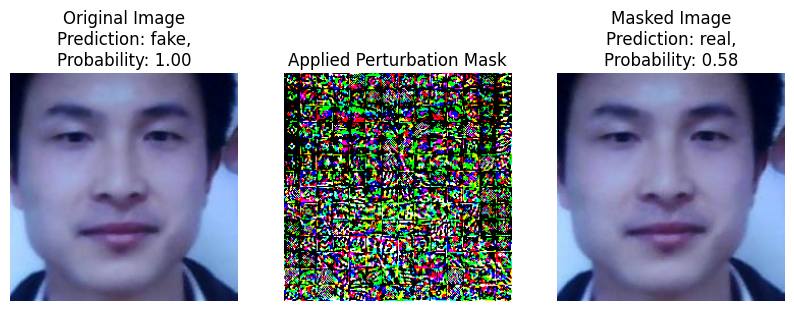

In [14]:

masked_img_tensor = img_tensor + mask_parameter

with torch.no_grad():
    output = model(img_tensor)
    masked = model(masked_img_tensor)
    
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()

    prediction = labels[int(output[0].argmax())]
    mask_prediction = labels[int(masked[0].argmax())]

    img_pil = tensor_to_pil(img_tensor)
    masked_pil = tensor_to_pil(masked_img_tensor)
    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 3, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction},\nProbability: {probs:.2f}")
plt.axis('off')

mask_pil = transforms.functional.to_pil_image(mask_parameter[0])
plt.subplot(1, 3, 2)
plt.imshow(mask_pil)
plt.title(f"Applied Perturbation Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(masked_pil)
plt.title(f"Masked Image\nPrediction: {mask_prediction},\nProbability: {mask_probs:.2f}")
plt.axis('off')

plt.show()

In [15]:
masked_pil= tensor_to_pil(masked_img_tensor)
masked_pil.save(fp="../static/adversarial/output_a.png")

## Security Measures

Address the security aspects to protect the integrity of the liveness detection process. Discuss potential system vulnerabilities and your strategies to mitigate them.


There are a set of security measures to take care, for this case lets see some of them:

1. The next is one example of how the quality of the image (format) can impact our attack and how the model can detect better png images.


In [48]:
# your code here
masked_pil= tensor_to_pil(masked_img_tensor)
masked_pil.save(fp="output.jpg")

# load the same img

new_img = Image.open("output.jpg")

# Just evaluating

with torch.no_grad():
    jpg_img_array = transform_original(new_img).to(device).unsqueeze(0)
    outputs = model(jpg_img_array)[0].argmax()

print("Target index jpg is:", outputs)
print("Target label jpg is:", labels[int(outputs)])

# repeat for PNG
masked_pil.save(fp='output.png')

new_img = Image.open("output.png")

with torch.no_grad():
    png_img_array = transform_original(new_img).to(device).unsqueeze(0)
    outputs = model(png_img_array)[0].argmax()

print("Target index png is:", outputs)
print("Target label png is:", labels[int(outputs)])

Target index jpg is: tensor(0, device='cuda:0')
Target label jpg is: fake
Target index png is: tensor(1, device='cuda:0')
Target label png is: real


Our attack was an open box (white blox approach) where we have an open access to the model, the next are a set of aspects to take care in our systems:

2. Don't share the model, take care to be victim using a pretrained model (for example HuggingFace).
3. Don't provide an API access to the model, there are ways to estimate the gradients from the scores of the model.
4. The API access returns the label of the input, there are noiser techniques that estimate gradiends based on sampling.
5. Don't provide any access to the training resources of the model, an attacker might affect it and poison the information which will affect the availability and integrity of the system.
6. Take care to log everything, logs can carry PII and confidential information, if something falls into the wrong hands, a dangerous person or an enemy might start to own or control it.
7. As with any service, it is important to test it and to determine the capacities to mitigate any DDoS.
8. Guardrails should be great to include to mitigate any unauthorized access to the model. 
9. Secure learning should be applied to these adversarial scenarios, the idea is to reinforce the model against these types of attacks.  
10. Implement an architecture with a set of pretrained models and other tools, the idea is to refine any true positive. 
11. Take care of false positives and false negatives results and save it to reinforce the system in future work.